In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures


In [2]:
dataLoad = pd.read_csv('train.csv', parse_dates=['date'])[['store_nbr','date','sales','onpromotion']]
dataLoad

,store_nbr,date,sales,onpromotion
0,1,2013-01-01,0.000,0
1,1,2013-01-01,0.000,0
2,1,2013-01-01,0.000,0
3,1,2013-01-01,0.000,0
4,1,2013-01-01,0.000,0
...,...,...,...,...
3000883,9,2017-08-15,438.133,0
3000884,9,2017-08-15,154.553,1
3000885,9,2017-08-15,2419.729,148
3000886,9,2017-08-15,121.000,8


In [3]:
dataLoad["date"] = pd.to_datetime(dataLoad["date"])

In [4]:
dataLoad = pd.DataFrame(dataLoad.groupby('date').sum()[['sales','onpromotion']])
dataLoad['timeStep'] = np.arange(len(dataLoad.index))

In [5]:
holiday = pd.read_csv('holidays_events.csv', parse_dates=['date'])[['date' , 'type']]
holiday = holiday.set_index('date')
dataLoad = dataLoad.join(holiday, how='left')

In [6]:
dataLoad.fillna('normalDay', inplace=True)

In [7]:
oil = pd.read_csv('oil.csv', parse_dates=['date'])
oil = oil.set_index('date')
oil.iloc[0,0] = 90
oil.iloc[0,-1] = 90
dataLoad = dataLoad.join(oil, how='left')
dataLoad.fillna(90, inplace=True)

In [8]:
dataLoad.head()

,sales,onpromotion,timeStep,type,dcoilwtico
date,,,,,
2013-01-01,2511.618999,0,0,Holiday,90.00
2013-01-02,496092.417944,0,1,normalDay,93.14
2013-01-03,361461.231124,0,2,normalDay,92.97
2013-01-04,354459.677093,0,3,normalDay,93.12
2013-01-05,477350.121229,0,4,Work Day,90.00


In [9]:
label_encoder = LabelEncoder()
dataLoad['type'] = label_encoder.fit_transform(dataLoad['type'])
setAside = dataLoad
dataLoad.head()

,sales,onpromotion,timeStep,type,dcoilwtico
date,,,,,
2013-01-01,2511.618999,0,0,3,90.00
2013-01-02,496092.417944,0,1,6,93.14
2013-01-03,361461.231124,0,2,6,92.97
2013-01-04,354459.677093,0,3,6,93.12
2013-01-05,477350.121229,0,4,5,90.00


In [10]:
data = dataLoad[0:int(len(dataLoad)*.9)]
test = dataLoad[int(len(dataLoad)*.9):]

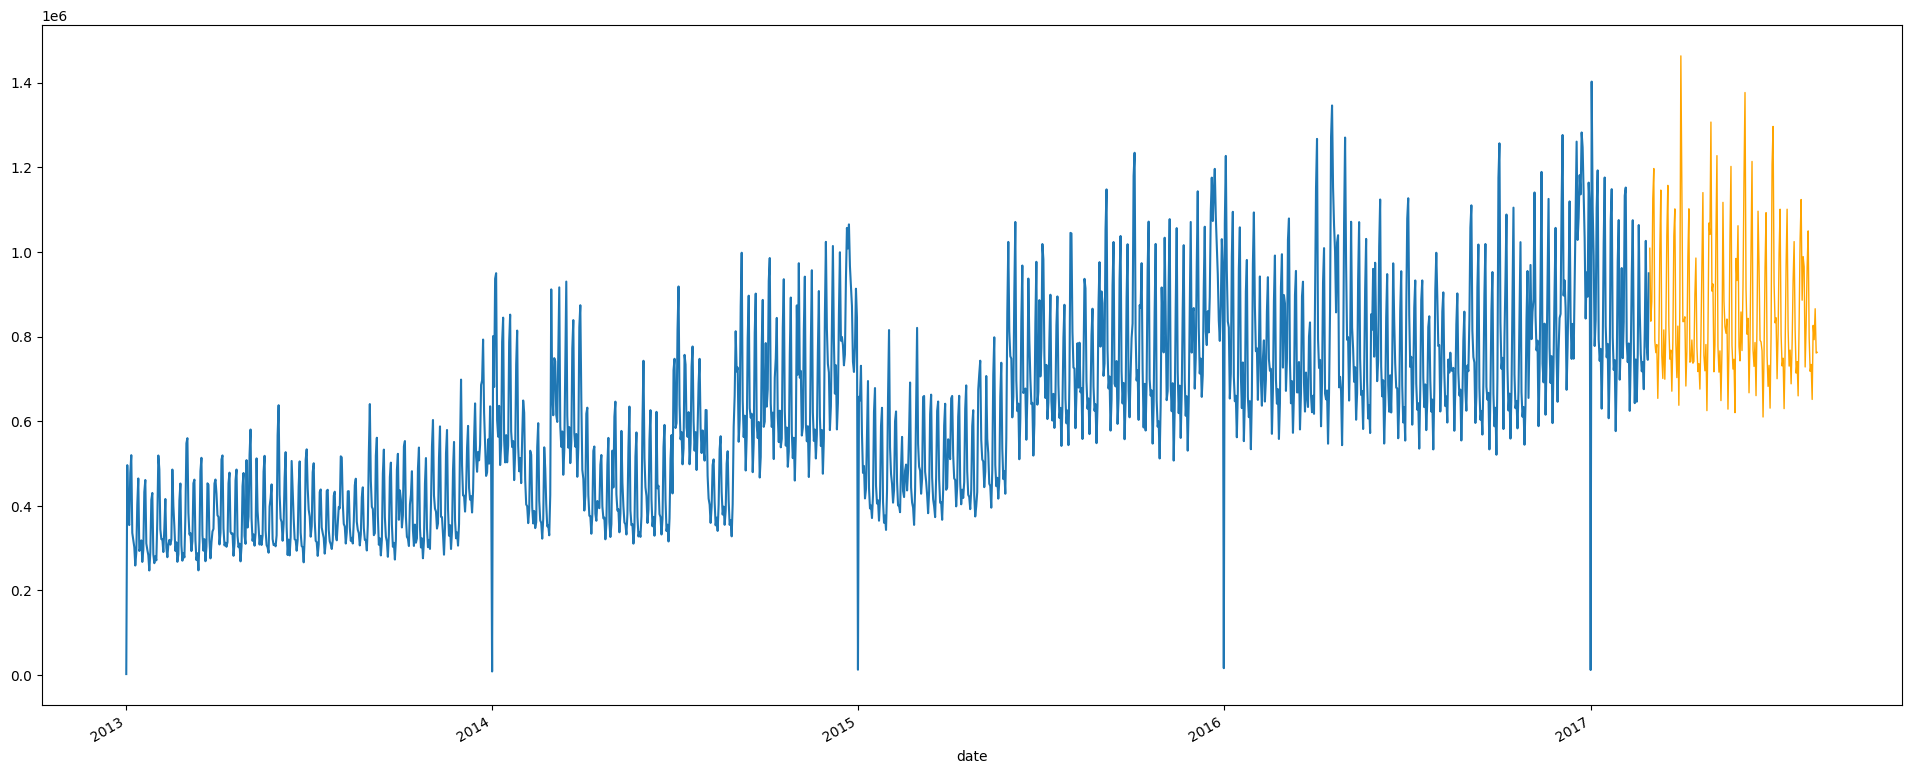

In [11]:
ax = data['sales'].plot(figsize =(24,10))
ax = test['sales'].plot(ax = ax, linewidth = 1,color = "orange")

In [12]:
def model(data,test,lag = False):
    model = LinearRegression()
    model.fit(data.iloc[:,1:], np.array(data['sales']).reshape(-1, 1))
    pred = pd.Series(model.predict(np.array(data.iloc[:,1:])).flatten())
    pred.index = data.index
    ax = data['sales'].plot(figsize =(24,10))
    ax = pred.plot(ax = ax, linewidth = 2)
    ax = test['sales'].plot(figsize =(24,10))
    
    if lag:
        lg = [data['OneDayLag'][-1]]

        test = test.drop('OneDayLag', axis=1)

        for i in range(len(test)):
        
            t = test.iloc[i, :].copy()  
            t['OneDayLag'] = lg[-1]
            predicted_lag = model.predict(pd.DataFrame([t]).iloc[:,1:])[0][0]
            lg.append(predicted_lag)

        test['OneDayLag'] = lg[:-1]
    
    
    predTest = pd.Series(model.predict(np.array(test.iloc[:,1:])).flatten())
    predTest.index = test.index
    ax = predTest.plot(ax = ax, linewidth = 2)
    ax
    #print(test)
        
    print("MSE on Train Data: " , mean_squared_error(pred, data['sales']))
    print("MSE on Test Data: " , mean_squared_error(predTest, test['sales']))


# Simple Linear Regression: Date ~ Time + totalPromotions + holiday + oilPrice

/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


MSE on Train Data:  22944876575.158318
MSE on Test Data:  27813630869.77782


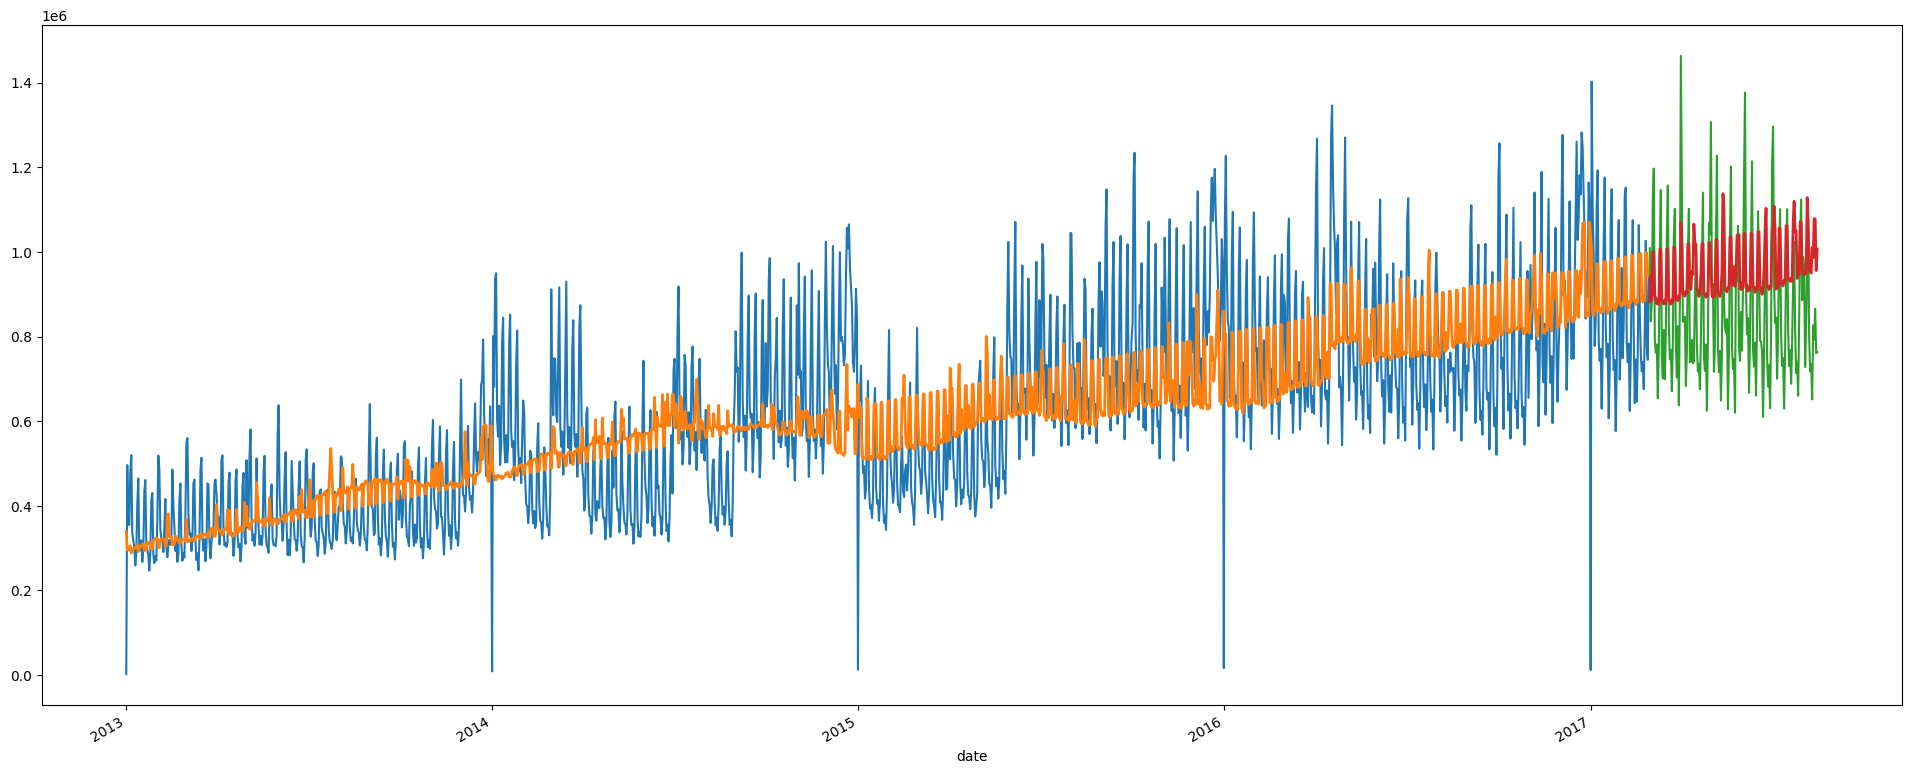

In [13]:
model(data,test)

# + Day of the Week


/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


MSE on Train Data:  20062955208.61296
MSE on Test Data:  22717543670.332138


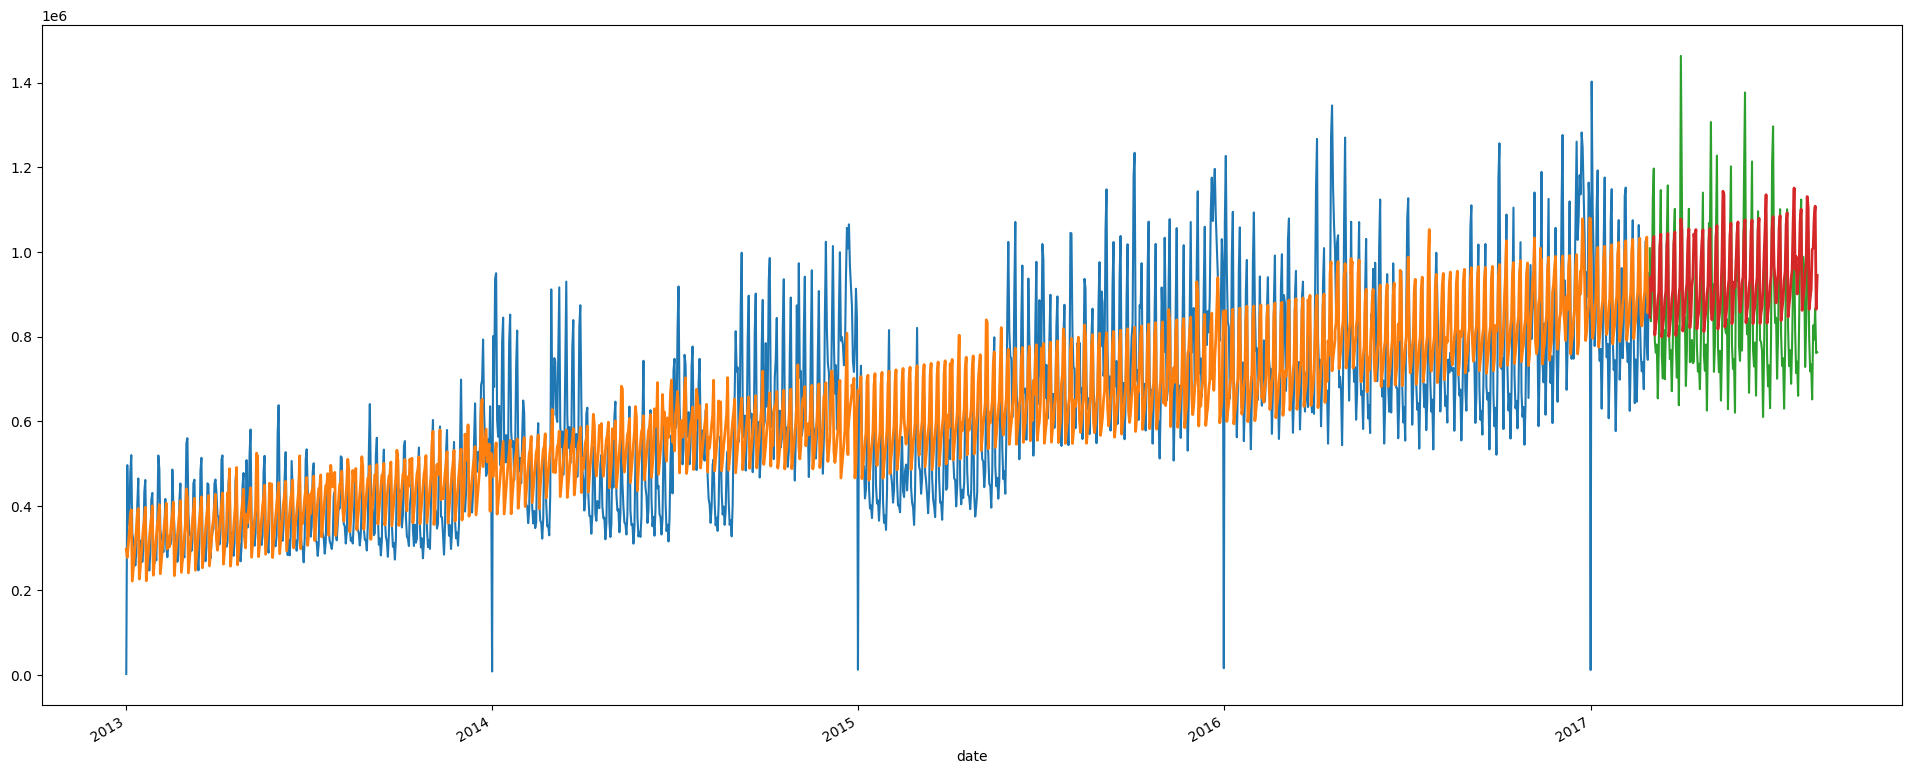

In [14]:
dataLoad['dotw'] = dataLoad.index.dayofweek
data = dataLoad[0:int(len(dataLoad)*.9)]
test = dataLoad[int(len(dataLoad)*.9):]
model(data,test)

# + Month + Year + isWeekend


/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


MSE on Train Data:  14560307478.39824
MSE on Test Data:  14368701271.900444


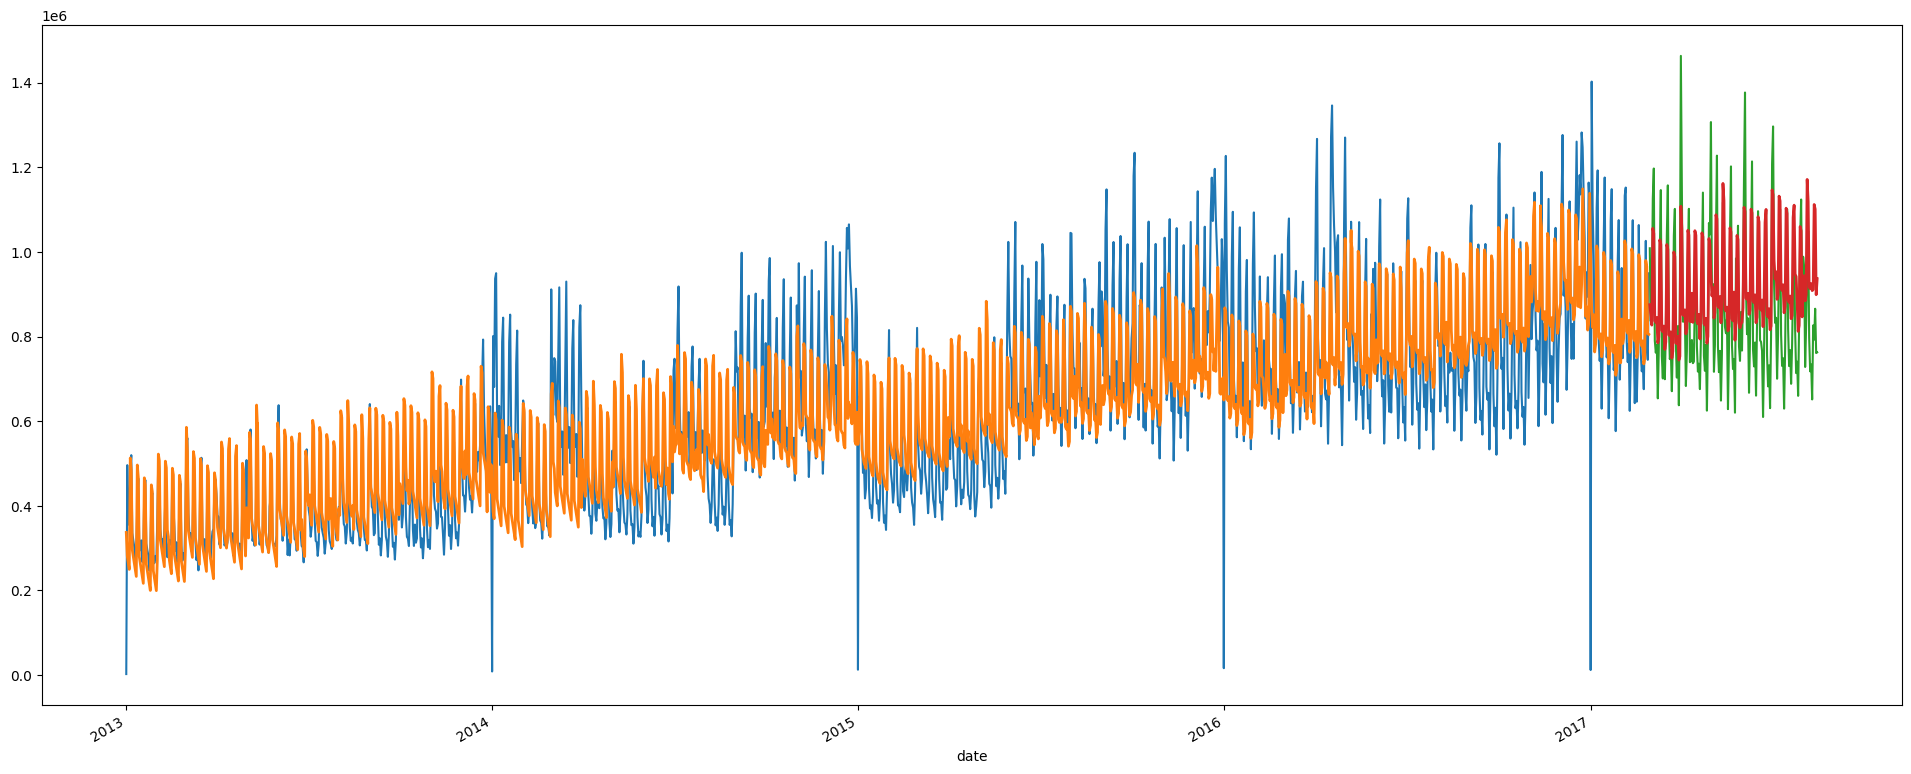

In [15]:
dataLoad['year'] = dataLoad.index.year
dataLoad['month'] = dataLoad.index.month
dataLoad['weekend'] = dataLoad['dotw'].isin([5, 6]).astype(int)
data = dataLoad[0:int(len(dataLoad)*.9)]
test = dataLoad[int(len(dataLoad)*.9):]
model(data,test)

# + One Day Lag Variable with predicted Lag Value

/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


MSE on Train Data:  9897790408.811344
MSE on Test Data:  17911808923.95205


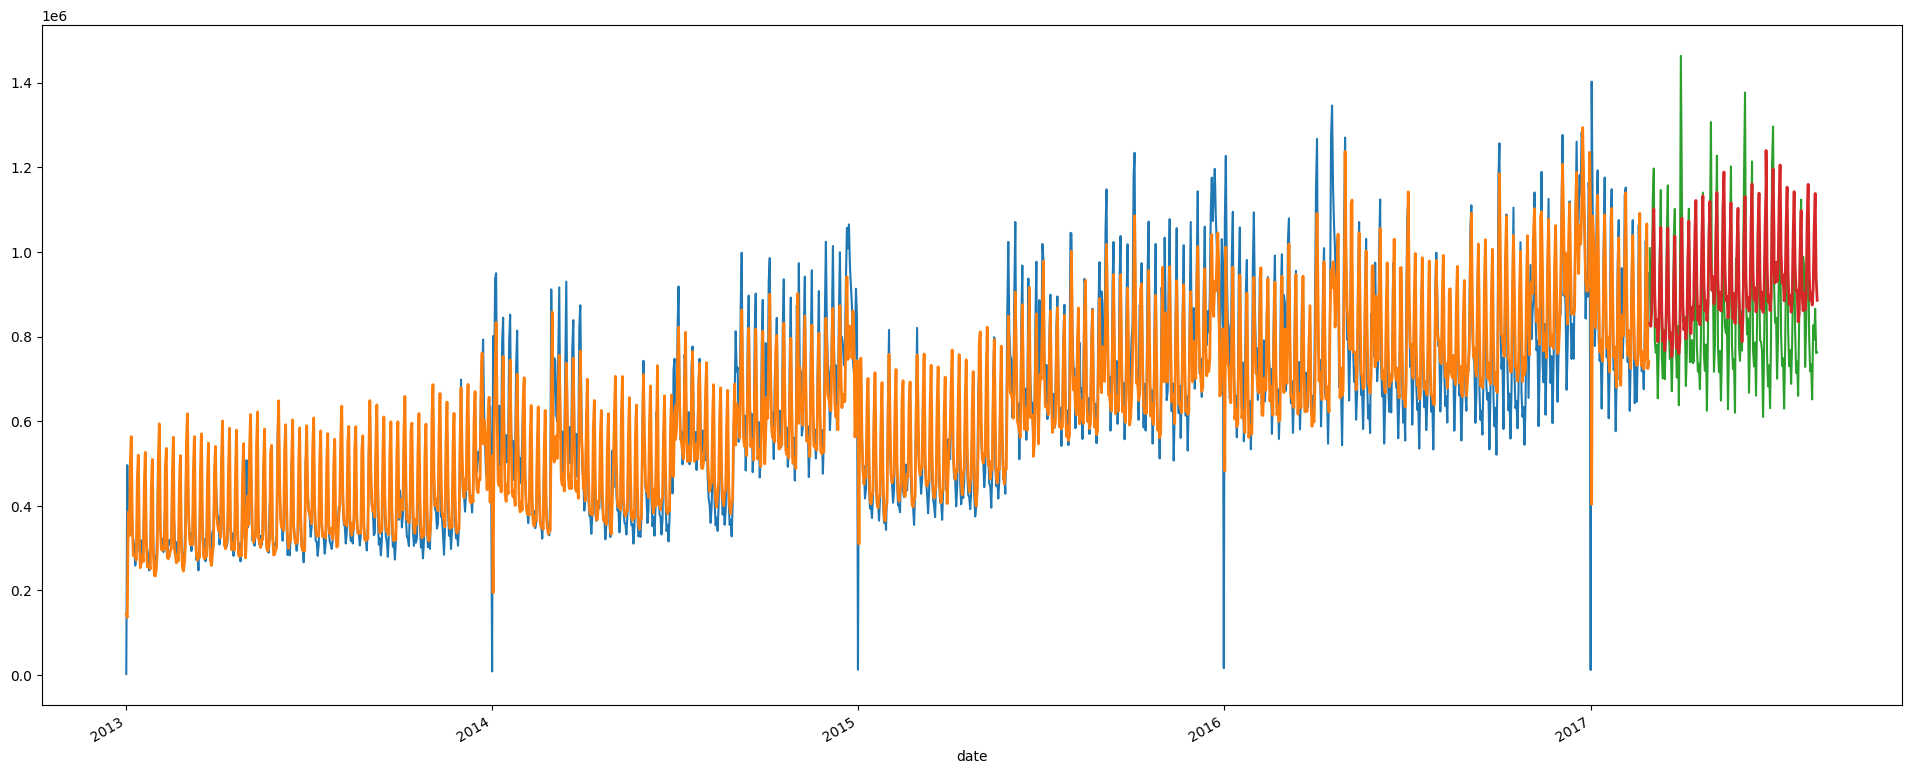

In [16]:
lag = np.array(dataLoad['sales'])
lag = np.insert(lag, 0, 2511)
dataLoad['OneDayLag'] = lag[0:-1]
data = dataLoad[0:int(len(dataLoad)*.9)]
test = dataLoad[int(len(dataLoad)*.9):]
model(data,test,True)

# One Day Lag With Known Lag?
Depending on goal, this might be allowed.

/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


MSE on Train Data:  9897790408.811344
MSE on Test Data:  11192768491.09722


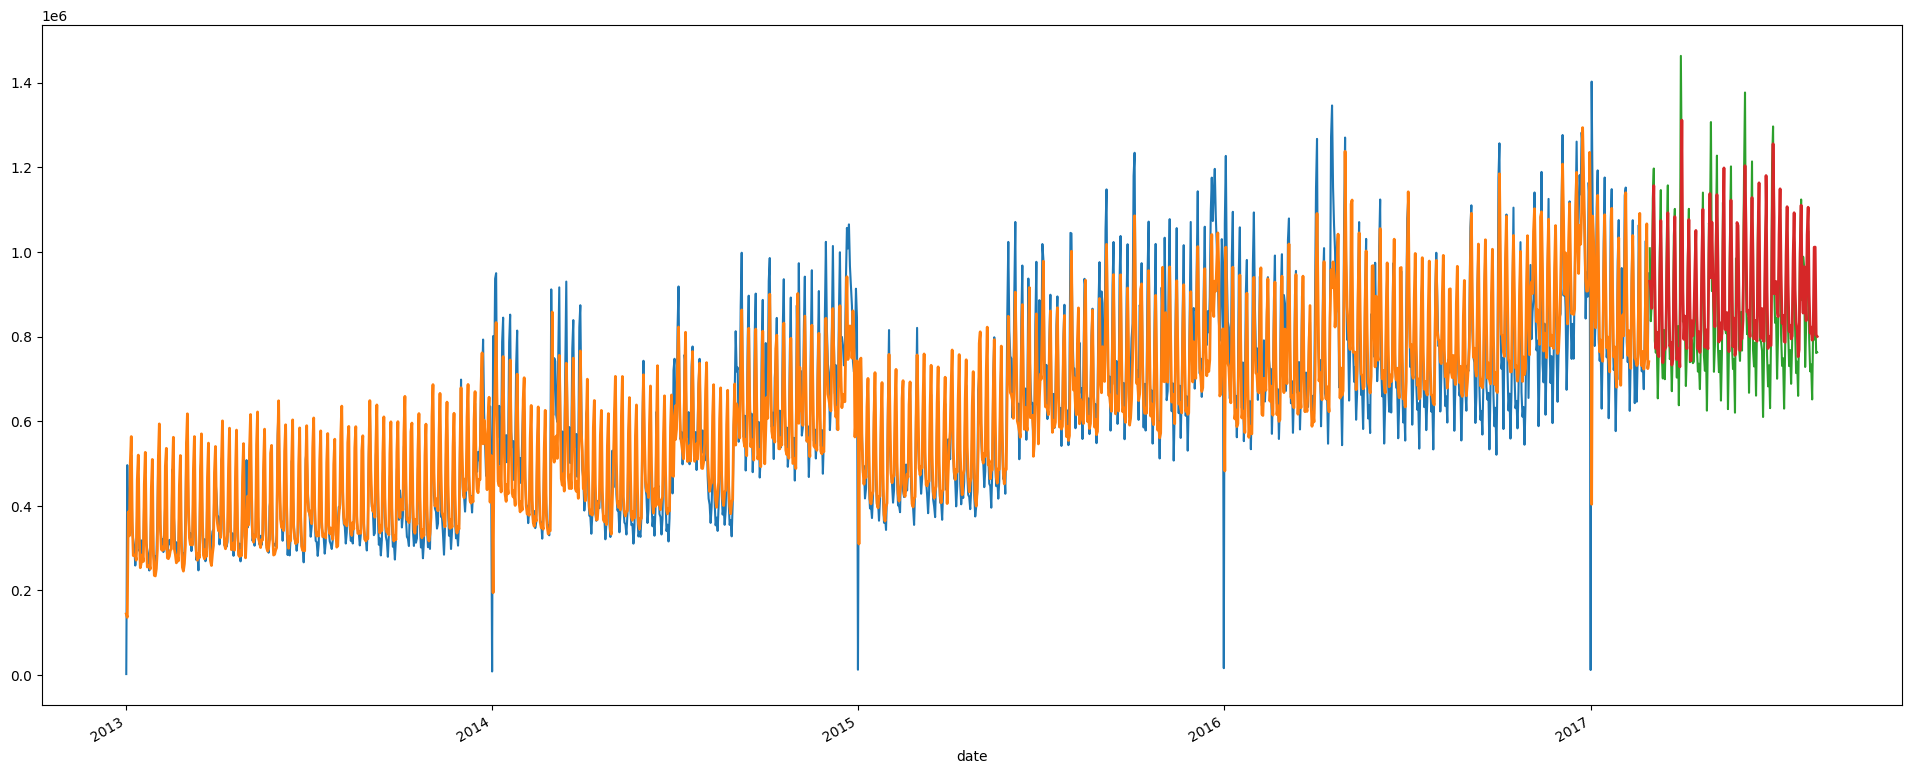

In [17]:
lag = np.array(dataLoad['sales'])
lag = np.insert(lag, 0, 2511)
dataLoad['OneDayLag'] = lag[0:-1]
data = dataLoad[0:int(len(dataLoad)*.9)]
test = dataLoad[int(len(dataLoad)*.9):]
model(data,test)

# Polynomial Features no lag

In [18]:
poly_features = PolynomialFeatures()
poly = pd.DataFrame(poly_features.fit_transform(np.array(dataLoad['timeStep']).reshape(-1, 1)),).iloc[:,1:]
poly.columns = poly.columns.astype(str)
poly.index = dataLoad.index
dataLoad = pd.concat([dataLoad,poly], axis=1)

/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


MSE on Train Data:  14184743872.240166
MSE on Test Data:  10283882383.528233


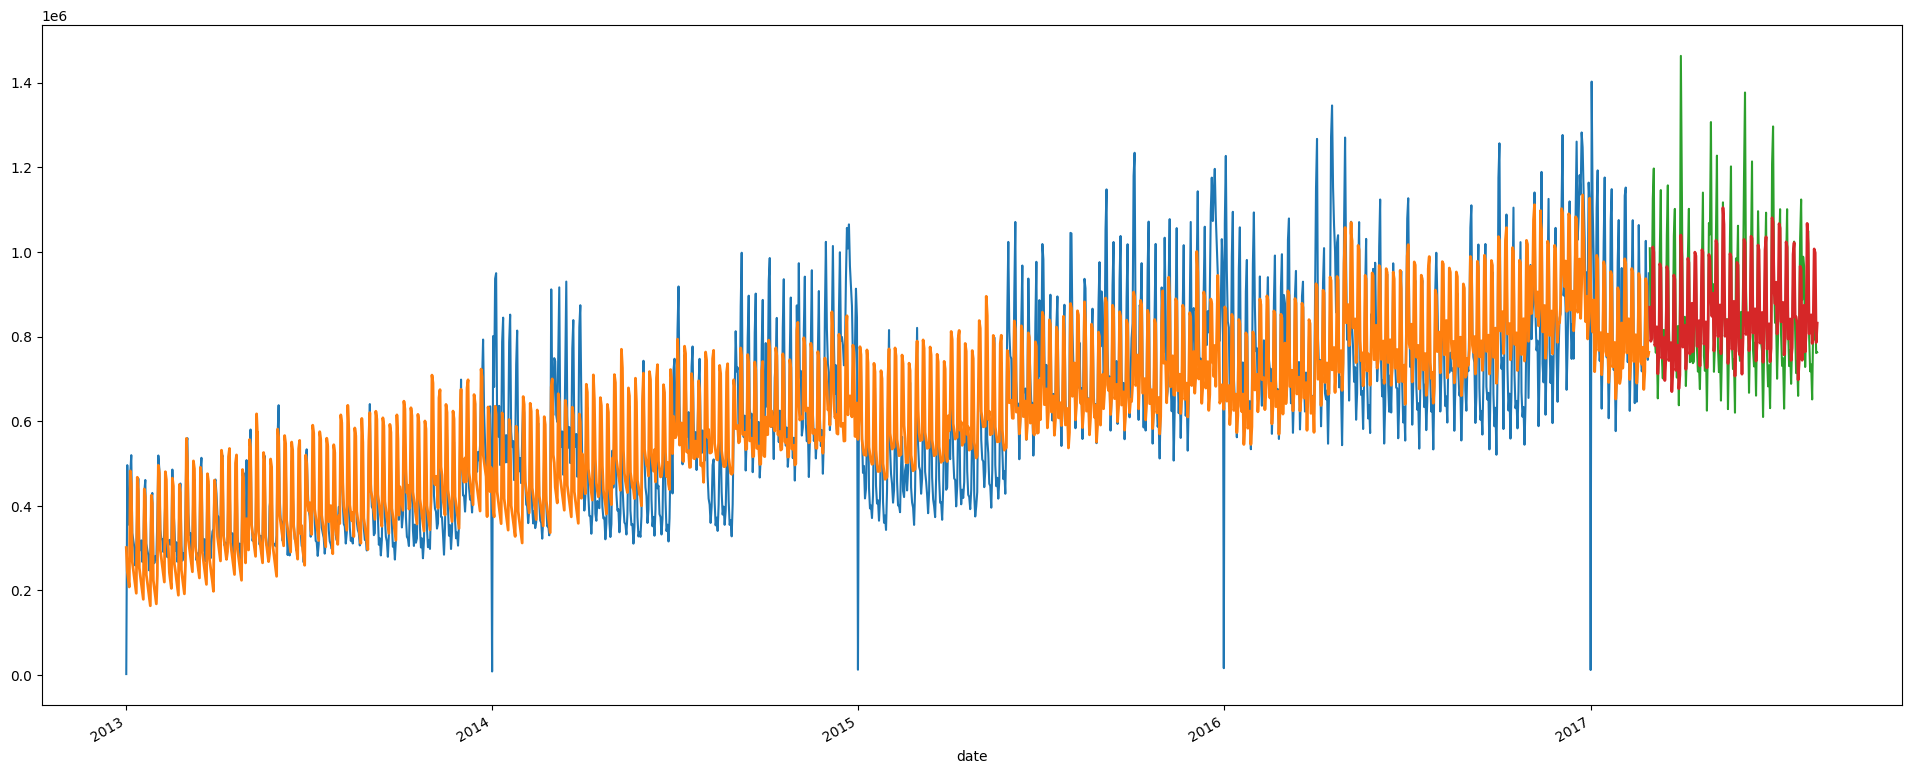

In [27]:
data = dataLoad[['sales','onpromotion', 'timeStep', 'type' ,'dcoilwtico', 'dotw','year','month','weekend','1','2']][0:int(len(dataLoad)*.9)]
test = dataLoad[['sales','onpromotion', 'timeStep', 'type' ,'dcoilwtico', 'dotw','year','month','weekend','1','2']][int(len(dataLoad)*.9):]
model(data,test)

# Polynomial With Lag

/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/samherold/anaconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


MSE on Train Data:  9439060466.86979
MSE on Test Data:  10132441905.878954


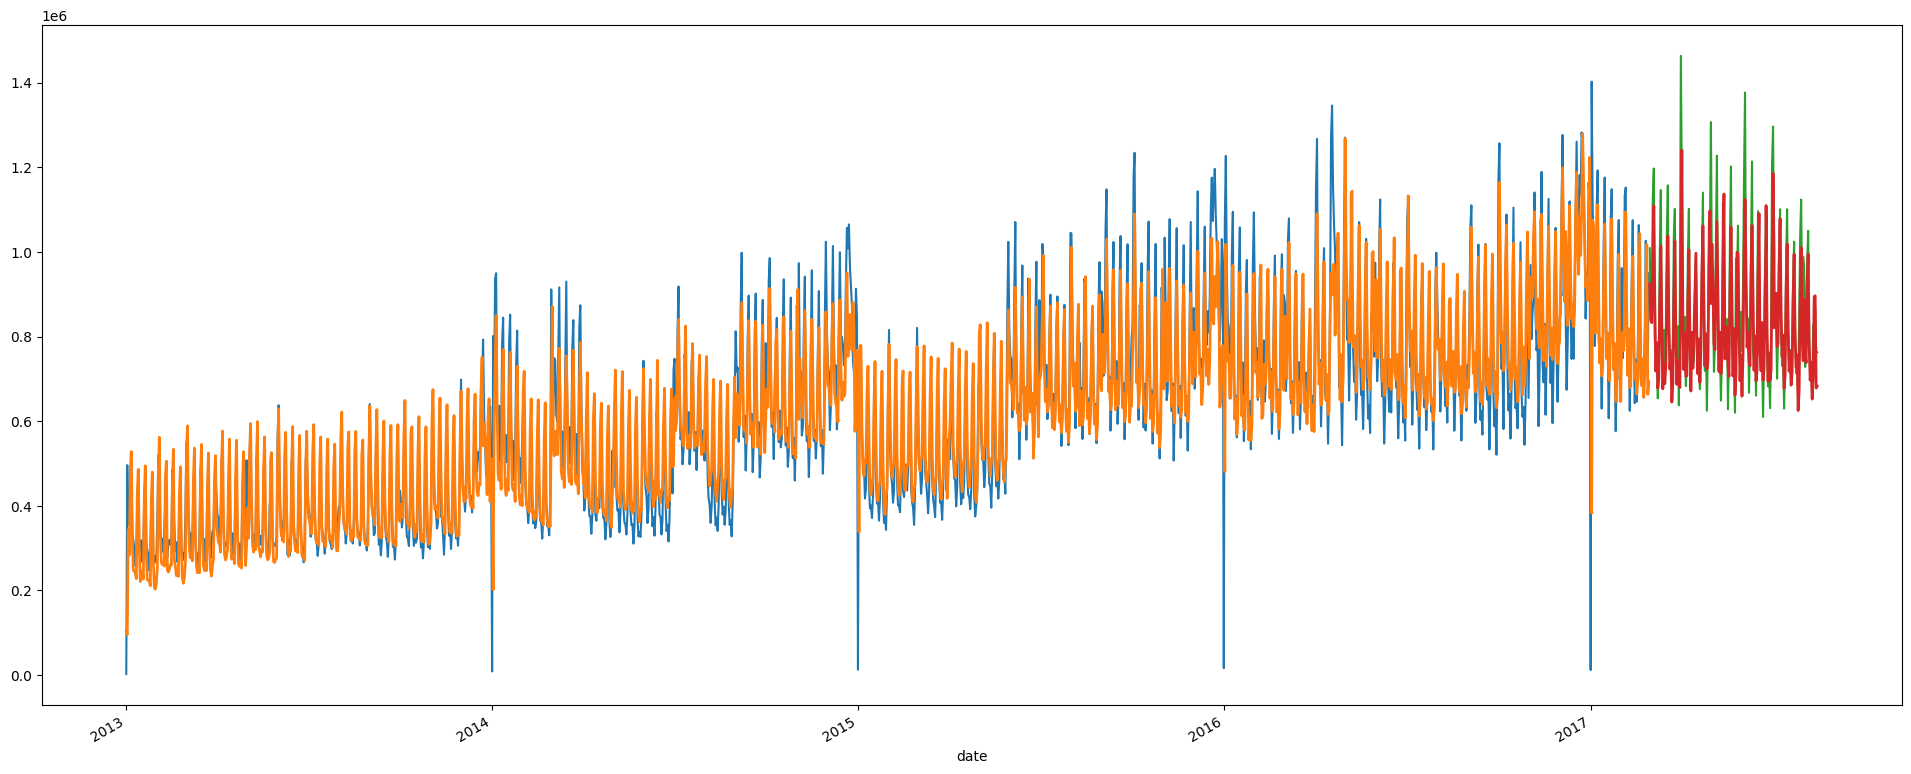

In [30]:
data = dataLoad[['sales','onpromotion', 'timeStep', 'type' ,'dcoilwtico', 'dotw','year','month','OneDayLag','weekend','1','2']][0:int(len(dataLoad)*.9)]
test = dataLoad[['sales','onpromotion', 'timeStep', 'type' ,'dcoilwtico', 'dotw','year','month','OneDayLag','weekend','1','2']][int(len(dataLoad)*.9):]
model(data,test)

In [33]:
dataLoad

,sales,onpromotion,timeStep,type,dcoilwtico,dotw,year,month,weekend,OneDayLag,1,2
date,,,,,,,,,,,,
2013-01-01,2511.618999,0,0,3,90.00,1,2013,1,0,2511.000000,0.0,0.0
2013-01-02,496092.417944,0,1,6,93.14,2,2013,1,0,2511.618999,1.0,1.0
2013-01-03,361461.231124,0,2,6,92.97,3,2013,1,0,496092.417944,2.0,4.0
2013-01-04,354459.677093,0,3,6,93.12,4,2013,1,0,361461.231124,3.0,9.0
2013-01-05,477350.121229,0,4,5,90.00,5,2013,1,1,354459.677093,4.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,826373.722022,14179,1679,4,48.81,4,2017,8,0,651386.911970,1679.0,2819041.0
2017-08-12,792630.535079,8312,1680,6,90.00,5,2017,8,1,826373.722022,1680.0,2822400.0
2017-08-13,865639.677471,9283,1681,6,90.00,6,2017,8,1,792630.535079,1681.0,2825761.0
